In [1]:
%matplotlib inline

import pandas
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import learn

/Users/ipolosukhin/projects/tf_examples/.env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Sets logging to INFO to see all information from TensorFlow.

tf.logging.set_verbosity(tf.logging.INFO)

In [18]:
BASE_DIR = 'adversarial_mnist/'

In [4]:
# Load data

mnist = learn.datasets.load_dataset('mnist')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


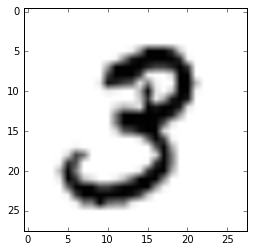

In [16]:
plt.imshow(np.reshape(mnist.train.images[1], (28, 28)), cmap='Greys')

In [136]:
def custom_model(features, target):
    target = tf.one_hot(target, 10, 1.0, 0.0)
    features = layers.fully_connected(features, 1024)
    logits = layers.fully_connected(features, 10, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    train_op = layers.optimize_loss(loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, optimizer='Adagrad')
    return tf.cast(tf.argmax(logits, dimension=1), tf.uint8), loss, train_op

custom_classifier = learn.Estimator(model_fn=custom_model, model_dir=BASE_DIR + 'custom')
custom_classifier.fit(x=mnist.train.images, y=mnist.train.labels, steps=500, batch_size=128)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 2.35218
INFO:tensorflow:Step 101: loss = 0.29118
INFO:tensorflow:Step 201: loss = 0.273693
INFO:tensorflow:Saving checkpoints for 300 into adversarial_mnist/custom/model.ckpt.
INFO:tensorflow:Step 301: loss = 0.189174
INFO:tensorflow:Step 401: loss = 0.301948
INFO:tensorflow:Saving checkpoints for 500 into adversarial_mnist/custom/model.ckpt.
INFO:tensorflow:Loss for final step: 0.280361.


Estimator(params=None)

In [137]:
pandas.DataFrame([custom_classifier.evaluate(x=mnist.validation.images, y=mnist.validation.labels, 
                                             metrics={'accuracy': tf.contrib.metrics.accuracy})])

INFO:tensorflow:Restored model from adversarial_mnist/custom/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.21205, accuracy = 0.9442


,accuracy,global_step,loss
0,0.9442,500,0.21205


In [131]:
# Utility function to create adversarial examples.

def get_adversarial_example(features, loss, norm):
    gradient = tf.gradients(loss, features, aggregation_method=2)
    gradient = tf.stop_gradient(gradient)
    r_adv = norm * tf.nn.l2_normalize(gradient, dim=1)
    r_adv = tf.reduce_sum(r_adv, reduction_indices=[0])
    return features + r_adv

In [68]:
# Monitor to display images for given tensors while training.

class ImageMonitor(learn.monitors.BaseMonitor):
    
    def __init__(self, tensor_names):
        super(ImageMonitor, self).__init__()
        self._tensor_names = tensor_names
    
    def step_begin(self, step):
        super(ImageMonitor, self).step_begin(step)
        return self._tensor_names
    
    def step_end(self, step, outputs):
        images = {}
        fig = plt.figure()
        for idx, name in enumerate(self._tensor_names):
            fig.add_subplot(1, len(self._tensor_names), idx + 1)
            plt.imshow(np.reshape(outputs[name][0], (28, 28)), cmap='Greys')
        return super(ImageMonitor, self).step_end(step, outputs)

In [132]:
ADV_LOSS_WEIGHT = 0.5

def adversarial_model(features, target, mode):
    tf.identity(features, name='features')
    target = tf.one_hot(target, 10, 1.0, 0.0, name='target')
    def model(features):
        features = layers.fully_connected(features, 1024)
        logits = layers.fully_connected(features, 10, activation_fn=None)
        return logits, tf.contrib.losses.softmax_cross_entropy(logits, target)
    with tf.variable_scope('model'):
        logits, orig_loss = model(features)
    adv_features = tf.identity(get_adversarial_example(features=features, loss=orig_loss, norm=0.1), name='adv_features')
    tf.identity(adv_features - features, name='adv_diff')
    with tf.variable_scope('model', reuse=True):
        adv_logit, adv_loss = model(adv_features)
    adv_pred = tf.argmax(adv_logit, dimension=1, name='adv_prediction')
    loss = orig_loss + ADV_LOSS_WEIGHT * adv_loss
    train_op = layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, optimizer='Adagrad')
    predictions = tf.cast(tf.argmax(logits, dimension=1, name='pred'), tf.uint8)
    return predictions, tf.reduce_mean(orig_loss), train_op

adversarial_classifier = learn.Estimator(model_fn=adversarial_model, model_dir=BASE_DIR + 'adversarial')
adversarial_classifier.fit(x=mnist.train.images, y=mnist.train.labels, steps=500, batch_size=128)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 2.30244
INFO:tensorflow:Step 101: loss = 0.257564
INFO:tensorflow:Step 201: loss = 0.238748
INFO:tensorflow:Saving checkpoints for 300 into adversarial_mnist/adversarial/model.ckpt.
INFO:tensorflow:Step 301: loss = 0.168112
INFO:tensorflow:Step 401: loss = 0.24352
INFO:tensorflow:Saving checkpoints for 500 into adversarial_mnist/adversarial/model.ckpt.
INFO:tensorflow:Loss for final step: 0.215602.


Estimator(params=None)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Restored model from adversarial_mnist/adversarial/model.ckpt-502-?????-of-00001
INFO:tensorflow:Step 503: pred = [8], adv_prediction = [8], target = [[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
INFO:tensorflow:Step 503: loss = 1.3113e-06
INFO:tensorflow:Saving checkpoints for 503 into adversarial_mnist/adversarial/model.ckpt.
INFO:tensorflow:Step 504: pred = [5], adv_prediction = [8], target = [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
INFO:tensorflow:Step 505: pred = [5], adv_prediction = [5], target = [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
INFO:tensorflow:Step 506: pred = [6], adv_prediction = [5], target = [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
INFO:tensorflow:Step 507: pred = [5], adv_prediction = [5], target = [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
INFO:tensorflow:Step 508: pred = [3], adv_prediction = [3], target = [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
INFO:tensorflow:Step 509: pred = [3], adv_prediction 

Estimator(params=None)

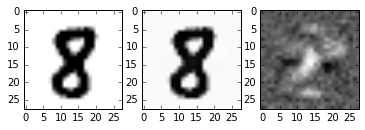

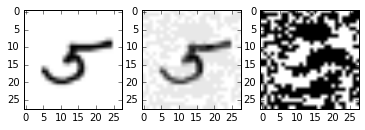

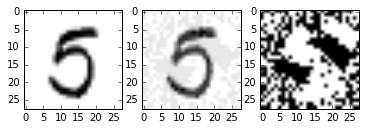

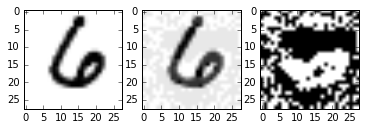

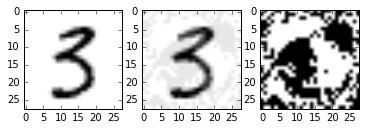

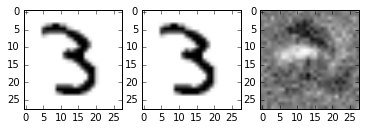

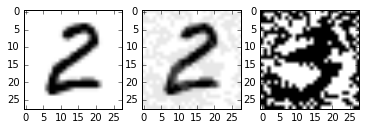

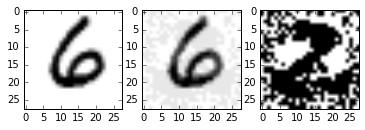

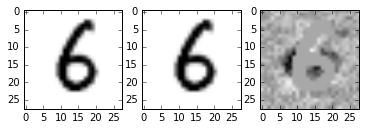

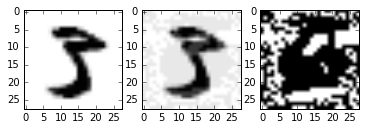

In [138]:
adversarial_classifier.fit(x=mnist.train.images, y=mnist.train.labels, steps=10, batch_size=1,
                           monitors=[ImageMonitor(['features', 'adv_features', 'adv_diff']),
                                     learn.monitors.PrintTensor(['pred', 'adv_prediction', 'target'], every_n=1)])

In [133]:
pandas.DataFrame([adversarial_classifier.evaluate(x=mnist.validation.images, y=mnist.validation.labels, 
                                                  metrics={'accuracy': tf.contrib.metrics.accuracy})])

INFO:tensorflow:Restored model from adversarial_mnist/adversarial/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.175563, accuracy = 0.9548


,accuracy,global_step,loss
0,0.9548,500,0.175563
